In [2]:
import pandas as pd
import os
import nf_model
import tarfile
from audio_image_pipeline import *
import json
import shutil
import random

#### Unpack compressed data

In [3]:
# Unpack data
def unpack_jsonwav_archive(archive_path, output_dir):
    """
    Unpack a .jsonwav.tar.gz archive, extracting only .wav and .json files.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    with tarfile.open(archive_path, 'r:gz') as tar:
        members = [m for m in tar.getmembers() if m.name.endswith(('.wav', '.json'))]
        tar.extractall(path=output_dir, members=members)
    print(f"Extracted {len(members)} files from {archive_path} to {output_dir}")
# unpack once after cloning
tar_file = 'nsynth-valid.jsonwav.tar.gz'
unpack_jsonwav_archive(
    'data/'+tar_file, # <- Add path to data here
    'data/'
)

Extracted 12679 files from data/nsynth-valid.jsonwav.tar.gz to data/


#### Convert .wav files to spectogram tensors

(10, 128, 126)


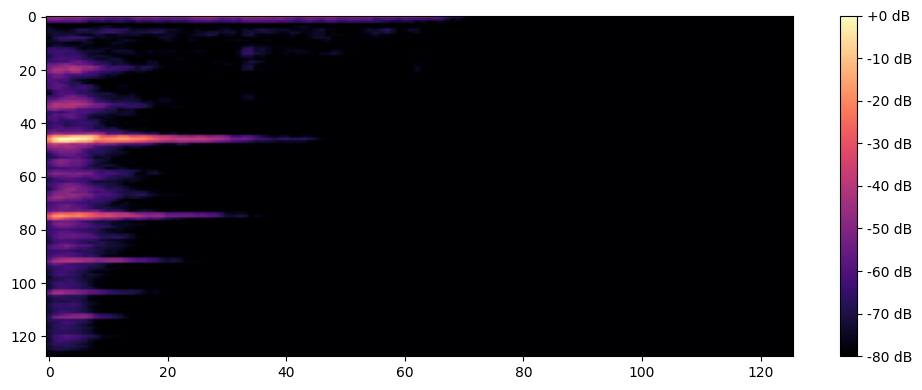

In [2]:
audio_path = 'data/sample_subset/audio/' # <-- insert path to audio

spectograms = [] 
for fname in os.listdir(audio_path):
    if not fname.endswith('.wav'):
        continue
    spec_t = audio_to_melspectrogram(
        os.path.join(audio_path, fname),
        sr=16000, n_mels=128, hop_length=512
    )
    spectograms.append(spec_t.numpy())

# stack into array of shape (N, 128, T)
data = np.stack(spectograms, axis=0)
print(data.shape)
plt.figure(figsize=(10,4))
plt.imshow(data[0], aspect='auto', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

#### Convert .json containing labels to dataframe

In [22]:
label_path = "data/nsynth-valid/"
json_path = os.path.join(label_path, "examples.json")

with open(json_path, 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()

,keyboard_acoustic_004-060-025,bass_synthetic_033-050-100,bass_synthetic_009-052-050,keyboard_electronic_003-064-127,bass_synthetic_034-030-050,bass_synthetic_098-040-025,bass_synthetic_009-083-075,mallet_acoustic_062-033-075,organ_electronic_113-028-075,keyboard_electronic_098-072-100,...,organ_electronic_007-042-050,keyboard_electronic_078-045-100,keyboard_electronic_003-047-075,vocal_acoustic_000-061-127,guitar_acoustic_014-048-127,bass_electronic_025-051-127,flute_synthetic_000-080-025,vocal_synthetic_003-073-025,bass_synthetic_134-036-100,keyboard_acoustic_004-044-127
note_str,keyboard_acoustic_004-060-025,bass_synthetic_033-050-100,bass_synthetic_009-052-050,keyboard_electronic_003-064-127,bass_synthetic_034-030-050,bass_synthetic_098-040-025,bass_synthetic_009-083-075,mallet_acoustic_062-033-075,organ_electronic_113-028-075,keyboard_electronic_098-072-100,...,organ_electronic_007-042-050,keyboard_electronic_078-045-100,keyboard_electronic_003-047-075,vocal_acoustic_000-061-127,guitar_acoustic_014-048-127,bass_electronic_025-051-127,flute_synthetic_000-080-025,vocal_synthetic_003-073-025,bass_synthetic_134-036-100,keyboard_acoustic_004-044-127
sample_rate,16000,16000,16000,16000,16000,16000,16000,16000,16000,16000,...,16000,16000,16000,16000,16000,16000,16000,16000,16000,16000
qualities_str,"[dark, reverb]",[dark],"[bright, distortion, long_release]",[],"[distortion, tempo-synced]",[dark],"[bright, distortion, long_release]","[dark, multiphonic]",[dark],[],...,"[distortion, long_release, nonlinear_env]",[bright],[],[reverb],[],[],[distortion],"[bright, distortion, long_release, nonlinear_env]","[dark, reverb]",[reverb]
instrument_source,0,2,2,1,2,2,2,0,1,1,...,1,1,1,0,0,1,2,2,2,0
instrument_family_str,keyboard,bass,bass,keyboard,bass,bass,bass,mallet,organ,keyboard,...,organ,keyboard,keyboard,vocal,guitar,bass,flute,vocal,bass,keyboard


## Explaining what each column in the data means


| Index | Qualität    | Beschreibung                        |
|-------|-------------|-----------------------------------|
| 0     | Bright      | Klang ist hell, klar               |
| 1     | Dark        | Klang ist dunkel, dumpf            |
| 2     | Distorted   | Klang ist verzerrt                 |
| 3     | Noisy       | Klang ist verrauscht               |
| 4     | Percussive  | Klang ist perkussiv (schlagzeugartig) |
| 5     | Sustained   | Klang ist gehalten, lang           |
| 6     | Harmonic    | Klang enthält viele Obertöne       |
| 7     | Metallic    | Klang klingt metallisch            |
| 8     | Vocal       | Klang klingt wie Stimme            |
| 9     | Other       | Andere unspezifizierte Eigenschaft |

## Preprocess Data and store as hdf5
We will convert the audio files to spectograms and store them as HDF5 for fast access

In [1]:
from audio_image_pipeline import preprocess_to_hdf5
preprocess_to_hdf5("data/nsynth-valid/audio", "data/trash_train_spectograms")

  1%|          | 132/12678 [00:03<05:49, 35.85it/s]


KeyboardInterrupt: 

In [11]:
import sys
import h5py
from tqdm import tqdm     # ← add this

def trim_hdf5(input_path, output_path):
    """
    Trim the last time-step (column) off each spectrogram in input_path
    and write the result to output_path.
    """
    with h5py.File(input_path, 'r') as f_in, h5py.File(output_path, 'w') as f_out:
        src = f_in['spectrograms']
        n, h, w = src.shape
        dst = f_out.create_dataset('spectrograms',
                                   shape=(n, h, w-1),
                                   dtype=src.dtype)
        # wrap the loop in tqdm
        for i in tqdm(range(n), desc="Trimming"):
            dst[i] = src[i, :, :-1]
    print(f"Trimmed {input_path} → {output_path} (new shape: {n}×{h}×{w-1})")

In [12]:
trim_hdf5('./data/train_spectrograms.h5', './data/train_spectrograms_even.h5')

Trimming:   0%|          | 0/289205 [00:00<?, ?it/s]

Trimming: 100%|██████████| 289205/289205 [02:36<00:00, 1849.00it/s]


Trimmed ./data/train_spectrograms.h5 → ./data/train_spectrograms_even.h5 (new shape: 289205×128×172)


In [13]:
trim_hdf5('./data/valid_spectrograms.h5', './data/valid_spectrograms_even.h5')

Trimming: 100%|██████████| 12678/12678 [00:05<00:00, 2497.36it/s]

Trimmed ./data/valid_spectrograms.h5 → ./data/valid_spectrograms_even.h5 (new shape: 12678×128×172)
